# EDA 

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [37]:
train = pd.read_csv('train.csv')

In [38]:
# Identify categorical and numerical features
TARGET = 'Heart Disease'
ID_COL = 'id'

train_cols = [col for col in train.columns if col not in [ID_COL, TARGET]]
CATS = train[train_cols].select_dtypes(include=['object']).columns.tolist()
NUMS = train[train_cols].select_dtypes(exclude=['object']).columns.tolist()

In [39]:
skew_kurt_df = pd.DataFrame({
    'Feature': NUMS,
    'Skewness': [train[col].skew() for col in NUMS],
    'Kurtosis': [train[col].kurtosis() for col in NUMS],
    'Mean': [train[col].mean() for col in NUMS],
    'Std': [train[col].std() for col in NUMS]
})

skew_kurt_df['Skew_Type'] = skew_kurt_df['Skewness'].apply(
    lambda x: 'Highly Right' if x > 1 else ('Right' if x > 0.5 else ('Symmetric' if abs(x) <= 0.5 else ('Left' if x < -0.5 else 'Highly Left')))
)

skew_kurt_df = skew_kurt_df.sort_values('Skewness', key=abs, ascending=False)

print("="*80)
print("SKEWNESS AND KURTOSIS ANALYSIS")
print("="*80)
display(skew_kurt_df.style.background_gradient(subset=['Skewness', 'Kurtosis'], cmap='coolwarm'))

print("\nInterpretation:")
print("  • Skewness > 1 or < -1: Highly skewed (consider log transform)")
print("  • Skewness between -0.5 and 0.5: Approximately symmetric")
print("  • Kurtosis > 3: Heavy tails (more outliers)")
print("  • Kurtosis < 3: Light tails (fewer outliers)")

SKEWNESS AND KURTOSIS ANALYSIS



Interpretation:
  • Skewness > 1 or < -1: Highly skewed (consider log transform)
  • Skewness between -0.5 and 0.5: Approximately symmetric
  • Kurtosis > 3: Heavy tails (more outliers)
  • Kurtosis < 3: Light tails (fewer outliers)


In [40]:
print("="*80)
print("STATISTICAL SIGNIFICANCE TESTS (Numerical Features vs Target)")
print("="*80)
print("\nUsing Mann-Whitney U Test (non-parametric)")
print("H0: The distributions are the same")
print("H1: The distributions are different")
print(f"Significance Level: α = 0.05\n")

significance_results = []

for col in NUMS:
    groups = [train[train[TARGET] == val][col].values for val in sorted(train[TARGET].unique())]
    
    if len(groups) == 2:
        stat, p_value = stats.mannwhitneyu(groups[0], groups[1], alternative='two-sided')
        
        significance_results.append({
            'Feature': col,
            'Test_Statistic': stat,
            'P_Value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No',
            'Effect': 'Strong' if p_value < 0.01 else ('Moderate' if p_value < 0.05 else 'Weak')
        })

sig_df = pd.DataFrame(significance_results).sort_values('P_Value')
display(sig_df.style.background_gradient(subset=['P_Value'], cmap='RdYlGn_r'))

print(f"\nSignificant Features (p < 0.05): {sig_df[sig_df['Significant'] == 'Yes'].shape[0]}/{len(NUMS)}")

STATISTICAL SIGNIFICANCE TESTS (Numerical Features vs Target)

Using Mann-Whitney U Test (non-parametric)
H0: The distributions are the same
H1: The distributions are different
Significance Level: α = 0.05




Significant Features (p < 0.05): 12/13


In [41]:
#Try a BP binning 
def bp_flag(age, sbp):
    """
    age: years (int or float)
    sbp: systolic blood pressure (mm Hg)
    """

    # --- Determine age-based normal SBP ---
    if age < 40:
        normal_upper = 119
    elif age < 60:
        normal_upper = 124
    else:
        normal_upper = 139

    # --- BP category based on systolic ---
    if sbp < normal_upper:
        return 'normal'
    elif sbp < 129:
        return 'elevated'
    elif sbp < 139:
        return 'stage_1'
    elif sbp < 180:
        return 'stage_2'
    else:
        return 'hypertensive_crisis'
    
train['bp_category'] = train.apply(lambda row: bp_flag(row['Age'], row['BP']), axis=1)
#map to numerical
bp_mapping = {
    'normal': 0,
    'elevated': 1,
    'stage_1': 2,
    'stage_2': 3,
    'hypertensive_crisis': 4
}

train['bp_category_num'] = train['bp_category'].map(bp_mapping)

In [42]:
# try again the statistical significance test with the new feature
print("="*80)
print("STATISTICAL SIGNIFICANCE TEST FOR NEW FEATURE 'bp_category_num'")
print("="*80)
print("\nUsing Mann-Whitney U Test (non-parametric)")
print("H0: The distributions are the same")
print("H1: The distributions are different")
print(f"Significance Level: α = 0.05\n")
groups = [train[train[TARGET] == val]['bp_category_num'].values for val in sorted(train[TARGET].unique())]
stat, p_value = stats.mannwhitneyu(groups[0], groups[1], alternative='two-sided')
print(f"Test Statistic: {stat:.4f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: Significant difference between groups (reject H0)")
    if p_value < 0.01:
        effect = 'Strong'
    else:
        effect = 'Moderate'
    print(f"Effect Size: {effect}")
else:
    print("Result: No significant difference between groups (fail to reject H0)")
print("="*80)


STATISTICAL SIGNIFICANCE TEST FOR NEW FEATURE 'bp_category_num'

Using Mann-Whitney U Test (non-parametric)
H0: The distributions are the same
H1: The distributions are different
Significance Level: α = 0.05

Test Statistic: 50121966375.5000, P-Value: 0.0000
Result: Significant difference between groups (reject H0)
Effect Size: Strong


In [43]:
#drop bp
train = train.drop(columns=['BP', 'bp_category'])

In [44]:
# run the skewness and kurtosis analysis again
train_cols = [col for col in train.columns if col not in [ID_COL, TARGET]]
CATS = train[train_cols].select_dtypes(include=['object']).columns.tolist()
NUMS = train[train_cols].select_dtypes(exclude=['object']).columns.tolist()
skew_kurt_df = pd.DataFrame({
    'Feature': NUMS,
    'Skewness': [train[col].skew() for col in NUMS],
    'Kurtosis': [train[col].kurtosis() for col in NUMS],
    'Mean': [train[col].mean() for col in NUMS],
    'Std': [train[col].std() for col in NUMS]
})
skew_kurt_df['Skew_Type'] = skew_kurt_df['Skewness'].apply(
    lambda x: 'Highly Right' if x > 1 else ('Right' if x > 0.5 else ('Symmetric' if abs(x) <= 0.5 else ('Left' if x < -0.5 else 'Highly Left')))
)
skew_kurt_df = skew_kurt_df.sort_values('Skewness', key=abs, ascending=False)
print("="*80)
print("SKEWNESS AND KURTOSIS ANALYSIS AFTER BP FEATURE ENGINEERING")
print("="*80)
display(skew_kurt_df.style.background_gradient(subset=['Skewness', 'Kurtosis'], cmap='coolwarm'))
print("\nInterpretation:")
print("  • Skewness > 1 or < -1: Highly skewed (consider log transform)")
print("  • Skewness between -0.5 and 0.5: Approximately symmetric")
print("  • Kurtosis > 3: Heavy tails (more outliers)")
print("  • Kurtosis < 3: Light tails (fewer outliers)")
print("="*80)

SKEWNESS AND KURTOSIS ANALYSIS AFTER BP FEATURE ENGINEERING



Interpretation:
  • Skewness > 1 or < -1: Highly skewed (consider log transform)
  • Skewness between -0.5 and 0.5: Approximately symmetric
  • Kurtosis > 3: Heavy tails (more outliers)
  • Kurtosis < 3: Light tails (fewer outliers)


In [45]:
train['stress_score'] = (
    train['Exercise angina'].astype(int)
    + (train['ST depression'] > 1).astype(int)
    + (train['Slope of ST'] == 2).astype(int)
)

# run the skewness and kurtosis analysis again with the new feature and statistical test
train_cols = [col for col in train.columns if col not in [ID_COL, TARGET]]
CATS = train[train_cols].select_dtypes(include=['object']).columns.tolist()
NUMS = train[train_cols].select_dtypes(exclude=['object']).columns.tolist()

skew_kurt_df = pd.DataFrame({
    'Feature': NUMS,
    'Skewness': [train[col].skew() for col in NUMS],
    'Kurtosis': [train[col].kurtosis() for col in NUMS],
    'Mean': [train[col].mean() for col in NUMS],
    'Std': [train[col].std() for col in NUMS]
})
skew_kurt_df['Skew_Type'] = skew_kurt_df['Skewness'].apply(
    lambda x: 'Highly Right' if x > 1 else ('Right' if x > 0.5 else ('Symmetric' if abs(x) <= 0.5 else ('Left' if x < -0.5 else 'Highly Left')))
)
skew_kurt_df = skew_kurt_df.sort_values('Skewness', key=abs, ascending=False)
print("="*80)
print("SKEWNESS AND KURTOSIS ANALYSIS AFTER STRESS SCORE FEATURE ENGINEERING")
print("="*80)
display(skew_kurt_df.style.background_gradient(subset=['Skewness', 'Kurtosis'], cmap='coolwarm'))
print("\nInterpretation:")
print("  • Skewness > 1 or < -1: Highly skewed (consider log transform)")
print("  • Skewness between -0.5 and 0.5: Approximately symmetric")
print("  • Kurtosis > 3: Heavy tails (more outliers)")
print("  • Kurtosis < 3: Light tails (fewer outliers)")
print("="*80)
print("STATISTICAL SIGNIFICANCE TEST FOR NEW FEATURE 'stress_score'")
print("="*80)
print("\nUsing Mann-Whitney U Test (non-parametric)")
print("H0: The distributions are the same")
print("H1: The distributions are different")
print(f"Significance Level: α = 0.05\n")
groups = [train[train[TARGET] == val]['stress_score'].values for val in sorted(train[TARGET].unique())]
stat, p_value = stats.mannwhitneyu(groups[0], groups[1], alternative='two-sided')
print(f"Test Statistic: {stat:.4f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: Significant difference between groups (reject H0)")
    if p_value < 0.01:
        effect = 'Strong'
    else:
        effect = 'Moderate'
    print(f"Effect Size: {effect}")
else:
    print("Result: No significant difference between groups (fail to reject H0)")
print("="*80)


SKEWNESS AND KURTOSIS ANALYSIS AFTER STRESS SCORE FEATURE ENGINEERING



Interpretation:
  • Skewness > 1 or < -1: Highly skewed (consider log transform)
  • Skewness between -0.5 and 0.5: Approximately symmetric
  • Kurtosis > 3: Heavy tails (more outliers)
  • Kurtosis < 3: Light tails (fewer outliers)
STATISTICAL SIGNIFICANCE TEST FOR NEW FEATURE 'stress_score'

Using Mann-Whitney U Test (non-parametric)
H0: The distributions are the same
H1: The distributions are different
Significance Level: α = 0.05

Test Statistic: 18268384951.0000, P-Value: 0.0000
Result: Significant difference between groups (reject H0)
Effect Size: Strong


In [46]:
# now columns used in stress score drop the raw
train.drop(columns=['Exercise angina','ST depression','Slope of ST'],axis=1,inplace=True)

In [47]:
# checks on VIF of total dataset
from statsmodels.stats.outliers_influence import variance_inflation_factor

# X_train should be a DataFrame (not numpy array)
# Example: X_train = pd.DataFrame(X_train, columns=feature_names)

# 1️⃣ Add constant (important for VIF)
X_vif = train.drop(columns=['Heart Disease','id'],axis=1).copy()
X_vif['const'] = 1

# 2️⃣ Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

# 3️⃣ Remove constant row & sort
vif_data = vif_data[vif_data['feature'] != 'const']
vif_data = vif_data.sort_values(by='VIF', ascending=False)

print(vif_data)

                    feature       VIF
10             stress_score  1.418755
8                  Thallium  1.417016
7   Number of vessels fluro  1.229944
2           Chest pain type  1.198967
6                    Max HR  1.177682
1                       Sex  1.122575
0                       Age  1.058514
5               EKG results  1.054602
9           bp_category_num  1.022215
3               Cholesterol  1.006699
4              FBS over 120  1.002177


In [48]:
train.columns

Index(['id', 'Age', 'Sex', 'Chest pain type', 'Cholesterol', 'FBS over 120',
       'EKG results', 'Max HR', 'Number of vessels fluro', 'Thallium',
       'Heart Disease', 'bp_category_num', 'stress_score'],
      dtype='object')

# Now build A 5 fold cross validation using Optuna XGBOOST

In [49]:
#build a 5 fold cross validation model using ooptuna xgboost
import optuna
import numpy as np
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [50]:
train['Heart Disease'] = train['Heart Disease'].map({'Absence': 0, 'Presence': 1})

In [51]:
# make a train test split
from sklearn.model_selection import train_test_split

X = train.drop(columns=['Heart Disease','id'])   # replace 'target' with your label column
y = train['Heart Disease']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (504000, 11)
Test shape: (126000, 11)


In [21]:
!pip install -U xgboost --user

In [25]:
import optuna
import numpy as np
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


def objective(trial):

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",

        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),

        # 🔥 GPU SETTINGS
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        # "max_bin": 256,

        "random_state": 42
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(**params,early_stopping_rounds=50)

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            # early_stopping_rounds=50,
            verbose=False
        )

        preds = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, preds)
        auc_scores.append(auc)

    return np.mean(auc_scores)


# ---------------- RUN OPTUNA ---------------- #
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best CV AUC:", study.best_value)
print("Best Params:", study.best_params)

[I 2026-02-01 16:58:54,431] A new study created in memory with name: no-name-fa8c2f66-cdd8-4564-b1ad-ec83a1f1dac2
C:\Users\Shivansh\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:58:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  ----------
C:\Users\Shivansh\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:58:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  ----------
C:\Users\Shivansh\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:58:57] WARNING: C:\buildkite-

Best CV AUC: 0.9541019212653428
Best Params: {'n_estimators': 848, 'learning_rate': 0.07146382172480288, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.9529260156040184, 'colsample_bytree': 0.6226559354348953, 'gamma': 0.5873845515983713, 'reg_alpha': 0.6978543881450656, 'reg_lambda': 0.1406103727086555}


In [55]:
best_params = {
    'n_estimators': 848, 
    'learning_rate': 0.07146382172480288, 
    'max_depth': 3, 'min_child_weight': 3, 
    'subsample': 0.9529260156040184, 
    'colsample_bytree': 0.6226559354348953, 
    'gamma': 0.5873845515983713, 
    'reg_alpha': 0.6978543881450656, 
    'reg_lambda': 0.1406103727086555
}

In [56]:
# best_params = study.best_params 

final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_estimators=848,
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    # early_stopping_rounds=best_params['xgb_early_stopping_rounds'],
)

final_model.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6226559354348953, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=0.5873845515983713, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07146382172480288,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=848, n_jobs=None,
              num_parallel_tree=None, ...)

In [64]:
#prepare the lgbm model with 5 fold cross validation and optuna hyperparameter tuning

from lightgbm import LGBMClassifier

def objective_lgbm(trial):
    params = {
        "objective": "binary",
        "metric": "auc",

        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),

        # 🔥 GPU SETTINGS
        # "device": 'gpu',
        # "max_bin": 256,

        "random_state": 42
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = LGBMClassifier(**params)

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            # early_stopping_rounds=50,
            # verbose=False
        )

        preds = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, preds)
        auc_scores.append(auc)

    return np.mean(auc_scores)
study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm, n_trials=50)
print("Best CV AUC (LGBM):", study_lgbm.best_value)
print("Best Params (LGBM):", study_lgbm.best_params)

[I 2026-02-08 11:13:56,896] A new study created in memory with name: no-name-1862e434-1b7d-4ef0-aee9-15ecfb4198ca


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, numb

[I 2026-02-08 11:14:12,748] Trial 0 finished with value: 0.9537083526125762 and parameters: {'n_estimators': 237, 'learning_rate': 0.17156055449748028, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9681552787672529, 'colsample_bytree': 0.8375673466132245, 'reg_alpha': 2.1093085007665433, 'reg_lambda': 1.3706867166777288}. Best is trial 0 with value: 0.9537083526125762.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012619 seconds.
You can set `force_row_

[I 2026-02-08 11:14:47,736] Trial 1 finished with value: 0.9525023054549221 and parameters: {'n_estimators': 459, 'learning_rate': 0.010911517487180812, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.7204468765416021, 'colsample_bytree': 0.7586561882407846, 'reg_alpha': 4.545153873744887, 'reg_lambda': 1.7219352178779623}. Best is trial 0 with value: 0.9537083526125762.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:15:25,667] Trial 2 finished with value: 0.953583895726202 and parameters: {'n_estimators': 633, 'learning_rate': 0.26787065866488935, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.8218899371843396, 'colsample_bytree': 0.6855133198988201, 'reg_alpha': 1.5246719948318814, 'reg_lambda': 4.046524897362596}. Best is trial 0 with value: 0.9537083526125762.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013678 seconds.
You can set `force_row_

[I 2026-02-08 11:15:58,957] Trial 3 finished with value: 0.9534713864163955 and parameters: {'n_estimators': 533, 'learning_rate': 0.15505612522363812, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6502094140356331, 'colsample_bytree': 0.8299406962883461, 'reg_alpha': 3.2137369386353623, 'reg_lambda': 4.201878756614283}. Best is trial 0 with value: 0.9537083526125762.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threa

[I 2026-02-08 11:16:51,962] Trial 4 finished with value: 0.9536539912691119 and parameters: {'n_estimators': 893, 'learning_rate': 0.07362145613622172, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6584565815054066, 'colsample_bytree': 0.7038596917554174, 'reg_alpha': 0.9311843140503312, 'reg_lambda': 0.9719749750991757}. Best is trial 0 with value: 0.9537083526125762.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:17:12,061] Trial 5 finished with value: 0.9539634015775622 and parameters: {'n_estimators': 371, 'learning_rate': 0.29101257129219393, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.7069049366051817, 'colsample_bytree': 0.755746654404832, 'reg_alpha': 2.5302996823266186, 'reg_lambda': 3.7929083613972594}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012111 seconds.
You can set `force_row_

[I 2026-02-08 11:17:48,411] Trial 6 finished with value: 0.9536943913071653 and parameters: {'n_estimators': 603, 'learning_rate': 0.09667107412843969, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.832604167128268, 'colsample_bytree': 0.8334864030260627, 'reg_alpha': 3.318057743199369, 'reg_lambda': 0.9021738814277236}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:18:24,435] Trial 7 finished with value: 0.9531852358199051 and parameters: {'n_estimators': 575, 'learning_rate': 0.1868724974964177, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9696226026597758, 'colsample_bytree': 0.8886327700247671, 'reg_alpha': 2.4162546645367278, 'reg_lambda': 3.057447716877642}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013834 seconds.
You can set `force_row_

[I 2026-02-08 11:18:55,841] Trial 8 finished with value: 0.9537691503705101 and parameters: {'n_estimators': 505, 'learning_rate': 0.06707414412861512, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.7910861426416489, 'colsample_bytree': 0.8652882407828903, 'reg_alpha': 0.8656301904330632, 'reg_lambda': 3.038279529543451}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:23:30,774] Trial 9 finished with value: 0.9530287336621492 and parameters: {'n_estimators': 618, 'learning_rate': 0.2696565396248929, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.9077979181375037, 'colsample_bytree': 0.8503842641818791, 'reg_alpha': 4.170592761805418, 'reg_lambda': 1.5371889202110767}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:23:37,456] Trial 10 finished with value: 0.9487479004363232 and parameters: {'n_estimators': 106, 'learning_rate': 0.029276576859761736, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6081804698418929, 'colsample_bytree': 0.9778033768514087, 'reg_alpha': 0.08465414954189265, 'reg_lambda': 4.888498921893012}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012529 seconds.
You can set `force_row_

[I 2026-02-08 11:24:11,435] Trial 11 finished with value: 0.9538093813549734 and parameters: {'n_estimators': 379, 'learning_rate': 0.036718225258727824, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.7473637556027267, 'colsample_bytree': 0.6220482859071134, 'reg_alpha': 0.6785689838797999, 'reg_lambda': 2.8459528890920827}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:24:31,759] Trial 12 finished with value: 0.9527459206499482 and parameters: {'n_estimators': 309, 'learning_rate': 0.03163591566116684, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.7418621247724989, 'colsample_bytree': 0.6039673735291599, 'reg_alpha': 3.172581635925174, 'reg_lambda': 2.588256067189039}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:25:00,413] Trial 13 finished with value: 0.9533317408324973 and parameters: {'n_estimators': 346, 'learning_rate': 0.03115538705426882, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7431586166547486, 'colsample_bytree': 0.6066996676172992, 'reg_alpha': 1.5845365678072443, 'reg_lambda': 3.469634014810748}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013648 seconds.
You can set `force_row_

[I 2026-02-08 11:25:36,388] Trial 14 finished with value: 0.9528008029510561 and parameters: {'n_estimators': 400, 'learning_rate': 0.014607587029598133, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.6974943375348128, 'colsample_bytree': 0.6786996297706944, 'reg_alpha': 0.2676396702266066, 'reg_lambda': 2.149098541633321}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014296 seconds.
You can set `force_row_

[I 2026-02-08 11:26:29,976] Trial 15 finished with value: 0.9539114686284961 and parameters: {'n_estimators': 766, 'learning_rate': 0.0401002912675383, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.784326846599343, 'colsample_bytree': 0.762344173728837, 'reg_alpha': 1.76494367547131, 'reg_lambda': 0.024094172062924635}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:27:28,840] Trial 16 finished with value: 0.9537808988464626 and parameters: {'n_estimators': 785, 'learning_rate': 0.018873912858658432, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8797972923527619, 'colsample_bytree': 0.7659929600173443, 'reg_alpha': 1.8248770051866252, 'reg_lambda': 0.01339033745781455}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:28:13,267] Trial 17 finished with value: 0.9539063944956514 and parameters: {'n_estimators': 843, 'learning_rate': 0.10976456704974703, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.7880933644723476, 'colsample_bytree': 0.7682581669629133, 'reg_alpha': 2.6614125037951957, 'reg_lambda': 0.007182926680682655}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threa

[I 2026-02-08 11:29:08,191] Trial 18 finished with value: 0.9537073153507876 and parameters: {'n_estimators': 982, 'learning_rate': 0.052855533014063205, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6808728551403787, 'colsample_bytree': 0.9238999286401641, 'reg_alpha': 3.647083189943269, 'reg_lambda': 3.9001294985023454}. Best is trial 5 with value: 0.9539634015775622.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:29:52,839] Trial 19 finished with value: 0.9539712599132855 and parameters: {'n_estimators': 736, 'learning_rate': 0.04486825526179054, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8619609223630565, 'colsample_bytree': 0.7290451795519612, 'reg_alpha': 2.6739775589224934, 'reg_lambda': 4.653666761601272}. Best is trial 19 with value: 0.9539712599132855.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:30:01,881] Trial 20 finished with value: 0.950434924296691 and parameters: {'n_estimators': 140, 'learning_rate': 0.02291231802447709, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8708816277762502, 'colsample_bytree': 0.7188409278314246, 'reg_alpha': 4.977728572979556, 'reg_lambda': 4.882600510127584}. Best is trial 19 with value: 0.9539712599132855.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:30:37,730] Trial 21 finished with value: 0.953877757363 and parameters: {'n_estimators': 711, 'learning_rate': 0.05179520365722471, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.9226909453283494, 'colsample_bytree': 0.7377510384125658, 'reg_alpha': 2.6141510113671838, 'reg_lambda': 4.371282098607784}. Best is trial 19 with value: 0.9539712599132855.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:31:20,502] Trial 22 finished with value: 0.9539082955975381 and parameters: {'n_estimators': 732, 'learning_rate': 0.04813894990626906, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7777084534694406, 'colsample_bytree': 0.7960910217939962, 'reg_alpha': 2.1052243302449956, 'reg_lambda': 3.4965523913965586}. Best is trial 19 with value: 0.9539712599132855.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:32:02,414] Trial 23 finished with value: 0.9539735147540027 and parameters: {'n_estimators': 714, 'learning_rate': 0.04202873425164995, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8414706613625487, 'colsample_bytree': 0.6572119205251777, 'reg_alpha': 2.823615102947456, 'reg_lambda': 4.5105685255951915}. Best is trial 23 with value: 0.9539735147540027.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:32:42,730] Trial 24 finished with value: 0.9540442131022404 and parameters: {'n_estimators': 699, 'learning_rate': 0.07629506054142317, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8428837270580495, 'colsample_bytree': 0.6575250408974198, 'reg_alpha': 2.844486069498083, 'reg_lambda': 4.61953657610418}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:33:24,249] Trial 25 finished with value: 0.9540397831791694 and parameters: {'n_estimators': 678, 'learning_rate': 0.08172684585672875, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.84870150881586, 'colsample_bytree': 0.6503271970630576, 'reg_alpha': 3.7668167844071654, 'reg_lambda': 4.7246972476297415}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:34:03,816] Trial 26 finished with value: 0.9540322427861092 and parameters: {'n_estimators': 656, 'learning_rate': 0.08919270019705111, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8280302085984294, 'colsample_bytree': 0.6537035453355813, 'reg_alpha': 3.7040164617407996, 'reg_lambda': 4.505784608152444}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:34:45,883] Trial 27 finished with value: 0.954011601766657 and parameters: {'n_estimators': 651, 'learning_rate': 0.10469522254967437, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9304315442790478, 'colsample_bytree': 0.6475609262891323, 'reg_alpha': 4.040843058690036, 'reg_lambda': 4.969315103801289}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:35:44,654] Trial 28 finished with value: 0.9538578214596463 and parameters: {'n_estimators': 850, 'learning_rate': 0.07307583959711808, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.8123876024729764, 'colsample_bytree': 0.6437933263591676, 'reg_alpha': 3.8206713518235547, 'reg_lambda': 3.587694996871741}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:36:31,732] Trial 29 finished with value: 0.9537419314657238 and parameters: {'n_estimators': 669, 'learning_rate': 0.14780653712983963, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8937375825588549, 'colsample_bytree': 0.6737389191345619, 'reg_alpha': 4.45882350047627, 'reg_lambda': 4.579876160840153}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:37:29,176] Trial 30 finished with value: 0.954007623783024 and parameters: {'n_estimators': 954, 'learning_rate': 0.08393728166896, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.9445041925706941, 'colsample_bytree': 0.637176445706075, 'reg_alpha': 3.486179905486966, 'reg_lambda': 4.137506847614213}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:38:09,150] Trial 31 finished with value: 0.954003771219712 and parameters: {'n_estimators': 673, 'learning_rate': 0.11729883379466469, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9814044167524554, 'colsample_bytree': 0.6529585963042077, 'reg_alpha': 3.962721663719583, 'reg_lambda': 4.9724247216293405}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:38:32,890] Trial 32 finished with value: 0.9540391246151716 and parameters: {'n_estimators': 473, 'learning_rate': 0.12552925656643132, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8494827686454269, 'colsample_bytree': 0.7045246600299757, 'reg_alpha': 4.419976943310758, 'reg_lambda': 4.599160243895513}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:38:56,339] Trial 33 finished with value: 0.9540368175768762 and parameters: {'n_estimators': 450, 'learning_rate': 0.19724808335330365, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8518083334802486, 'colsample_bytree': 0.6983234050119338, 'reg_alpha': 4.950530740109463, 'reg_lambda': 4.3396870949732}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:39:20,642] Trial 34 finished with value: 0.9540356684090142 and parameters: {'n_estimators': 458, 'learning_rate': 0.17237182880859767, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.8608594879868854, 'colsample_bytree': 0.7026082693585274, 'reg_alpha': 4.996932015803513, 'reg_lambda': 4.209741980731166}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:39:45,095] Trial 35 finished with value: 0.9540354623779184 and parameters: {'n_estimators': 481, 'learning_rate': 0.2154750141540208, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.8486226290977688, 'colsample_bytree': 0.6989096482563568, 'reg_alpha': 4.58169559787254, 'reg_lambda': 3.821118647184611}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:40:00,201] Trial 36 finished with value: 0.9538390210239521 and parameters: {'n_estimators': 256, 'learning_rate': 0.13617717128620443, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.8095765444283395, 'colsample_bytree': 0.6796272962143638, 'reg_alpha': 4.39466495797188, 'reg_lambda': 4.103252422310792}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:40:27,518] Trial 37 finished with value: 0.9540096386645036 and parameters: {'n_estimators': 532, 'learning_rate': 0.22157500769745422, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8863159757183378, 'colsample_bytree': 0.7992976531601528, 'reg_alpha': 4.6585675209392825, 'reg_lambda': 4.688955324003476}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:40:50,960] Trial 38 finished with value: 0.9536742672591061 and parameters: {'n_estimators': 430, 'learning_rate': 0.06440947339470396, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.9046513628233221, 'colsample_bytree': 0.6264823898640598, 'reg_alpha': 3.1094331978551475, 'reg_lambda': 4.278101746247505}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:41:24,244] Trial 39 finished with value: 0.9536442208286052 and parameters: {'n_estimators': 573, 'learning_rate': 0.1311834709722316, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.8475768945695776, 'colsample_bytree': 0.732432007615349, 'reg_alpha': 4.265664329359755, 'reg_lambda': 3.3666625070182974}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:42:00,201] Trial 40 finished with value: 0.9535762568153162 and parameters: {'n_estimators': 603, 'learning_rate': 0.18435433199961992, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.7668942845528325, 'colsample_bytree': 0.710018743879622, 'reg_alpha': 4.665612303210046, 'reg_lambda': 2.055886452957237}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:42:22,591] Trial 41 finished with value: 0.9540407725742645 and parameters: {'n_estimators': 448, 'learning_rate': 0.2082026848814139, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.8609581830702655, 'colsample_bytree': 0.6952106316953541, 'reg_alpha': 4.990300891279924, 'reg_lambda': 3.972383191786477}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:42:54,159] Trial 42 finished with value: 0.9538620622128058 and parameters: {'n_estimators': 543, 'learning_rate': 0.22499516288570762, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8274275515546234, 'colsample_bytree': 0.6677224538782232, 'reg_alpha': 4.837811054875652, 'reg_lambda': 3.948633495599872}. Best is trial 24 with value: 0.9540442131022404.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:43:16,378] Trial 43 finished with value: 0.954053356635155 and parameters: {'n_estimators': 448, 'learning_rate': 0.15697202681258118, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.858942207177411, 'colsample_bytree': 0.6869142563952703, 'reg_alpha': 4.153132598266781, 'reg_lambda': 4.405883815793842}. Best is trial 43 with value: 0.954053356635155.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:43:45,190] Trial 44 finished with value: 0.9539759987151031 and parameters: {'n_estimators': 503, 'learning_rate': 0.15708670166987268, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.8053965552521535, 'colsample_bytree': 0.6264620372290717, 'reg_alpha': 4.1333413309819225, 'reg_lambda': 4.8178879485018955}. Best is trial 43 with value: 0.954053356635155.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:44:03,085] Trial 45 finished with value: 0.9534182233643872 and parameters: {'n_estimators': 344, 'learning_rate': 0.06235778426340912, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.8767527460274492, 'colsample_bytree': 0.7443625447832707, 'reg_alpha': 3.447964443985033, 'reg_lambda': 3.759628897591651}. Best is trial 43 with value: 0.954053356635155.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:44:23,889] Trial 46 finished with value: 0.9538362503139867 and parameters: {'n_estimators': 413, 'learning_rate': 0.08383051077564235, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.902763231834284, 'colsample_bytree': 0.6900629802974079, 'reg_alpha': 4.281408291354263, 'reg_lambda': 3.23294674069229}. Best is trial 43 with value: 0.954053356635155.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:44:41,701] Trial 47 finished with value: 0.9540045875593337 and parameters: {'n_estimators': 296, 'learning_rate': 0.12562976048732366, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8303628236917326, 'colsample_bytree': 0.6106218763716613, 'reg_alpha': 3.894788784568491, 'reg_lambda': 4.7153352502712345}. Best is trial 43 with value: 0.954053356635155.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:45:12,671] Trial 48 finished with value: 0.9539795034474938 and parameters: {'n_estimators': 578, 'learning_rate': 0.2992519122620651, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.8672155686267844, 'colsample_bytree': 0.6674510477154821, 'reg_alpha': 4.70811734214198, 'reg_lambda': 4.432429455876843}. Best is trial 43 with value: 0.954053356635155.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180770, number of negative: 222430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 403200, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448338 -> initscore=-0.207387
[LightGBM] [Info] Start training from score -0.207387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2026-02-08 11:45:41,102] Trial 49 finished with value: 0.9538621718640176 and parameters: {'n_estimators': 495, 'learning_rate': 0.09727395756893104, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.954570599666581, 'colsample_bytree': 0.8165752389228226, 'reg_alpha': 2.9940506268645857, 'reg_lambda': 4.0408691438874245}. Best is trial 43 with value: 0.954053356635155.


Best CV AUC (LGBM): 0.954053356635155
Best Params (LGBM): {'n_estimators': 448, 'learning_rate': 0.15697202681258118, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.858942207177411, 'colsample_bytree': 0.6869142563952703, 'reg_alpha': 4.153132598266781, 'reg_lambda': 4.405883815793842}


In [65]:
#prepare test data
testing=pd.read_csv("test.csv")

In [66]:
#Try a BP binning 
def bp_flag(age, sbp):
    """
    age: years (int or float)
    sbp: systolic blood pressure (mm Hg)
    """

    # --- Determine age-based normal SBP ---
    if age < 40:
        normal_upper = 119
    elif age < 60:
        normal_upper = 124
    else:
        normal_upper = 139

    # --- BP category based on systolic ---
    if sbp < normal_upper:
        return 'normal'
    elif sbp < 129:
        return 'elevated'
    elif sbp < 139:
        return 'stage_1'
    elif sbp < 180:
        return 'stage_2'
    else:
        return 'hypertensive_crisis'
    
testing['bp_category'] = testing.apply(lambda row: bp_flag(row['Age'], row['BP']), axis=1)
#map to numerical
bp_mapping = {
    'normal': 0,
    'elevated': 1,
    'stage_1': 2,
    'stage_2': 3,
    'hypertensive_crisis': 4
}

testing['bp_category_num'] = testing['bp_category'].map(bp_mapping)


testing['stress_score'] = (
    testing['Exercise angina'].astype(int)
    + (testing['ST depression'] > 1).astype(int)
    + (testing['Slope of ST'] == 2).astype(int)
)

testing.drop(columns=['BP','Exercise angina','ST depression','Slope of ST','bp_category'],axis=1,inplace=True)

In [59]:
predictions=final_model.predict_proba(testing.drop(columns='id'))

In [60]:
predictions[:,1]

array([0.9249154 , 0.00887274, 0.98871976, ..., 0.04010423, 0.19905488,
       0.02451847], dtype=float32)

In [61]:
d={'id': testing['id'], 'Heart Disease': predictions[:,1]}
submission = pd.DataFrame(d)
submission.to_csv("submission.csv",index=False)

In [25]:
from scipy.stats import ks_2samp

for col in X.columns:
    stat, p = ks_2samp(X[col], testing[col])
    if p < 0.05:
        print(f"Drift detected in {col}")
    else:
        print("all fine")

all fine
all fine
all fine
all fine
all fine
all fine
all fine
all fine
all fine
all fine
all fine


In [70]:
#create a ensemble of the two models and submit the predictions with hard regularization of 0.95 

def shrink_params(params, factor=0.95):
    new_params = {}

    for k, v in params.items():
        if isinstance(v, (int, float)):
            new_v = v * factor

            # keep ints as ints
            if isinstance(v, int):
                new_v = max(1, int(round(new_v)))

            new_params[k] = new_v
        else:
            new_params[k] = v

    return new_params

lgbm_params = shrink_params(study_lgbm.best_params, 0.95)

model_lgbm = LGBMClassifier(**lgbm_params)
model_lgbm.fit(X, y)

xgb_best = best_params.copy()
xgb_best["n_estimators"] = 848   # your tuned value

xgb_params = shrink_params(xgb_best, 0.95)

model_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    **xgb_params
)

model_xgb.fit(X, y)

X_test = testing.drop(columns='id')

preds_xgb = model_xgb.predict_proba(X_test)[:, 1]
preds_lgbm = model_lgbm.predict_proba(X_test)[:, 1]

final_preds = 0.5 * preds_xgb + 0.5 * preds_lgbm

submission = pd.DataFrame({
    'id': testing['id'],
    'Heart Disease': final_preds
})

submission.to_csv("submission_ensemble_decay095.csv", index=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 282454, number of negative: 347546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448340 -> initscore=-0.207381
[LightGBM] [Info] Start training from score -0.207381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
#create a ensemble of the two models and submit the predictions

model_lgbm = LGBMClassifier(**study_lgbm.best_params)
model_lgbm.fit(X,y)

model_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_estimators=848,
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    # early_stopping_rounds=best_params['xgb_early_stopping_rounds'],
)
model_xgb.fit(X,y)

preds_xgb = model_xgb.predict_proba(testing.drop(columns='id'))[:, 1]
preds_lgbm = model_lgbm.predict_proba(testing.drop(columns='id'))[:, 1]
final_preds = 0.6 * preds_xgb + 0.4 * preds_lgbm
d={'id': testing['id'], 'Heart Disease': final_preds}
submission = pd.DataFrame(d)
submission.to_csv("submission_ensemble.csv",index=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 282454, number of negative: 347546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448340 -> initscore=-0.207381
[LightGBM] [Info] Start training from score -0.207381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

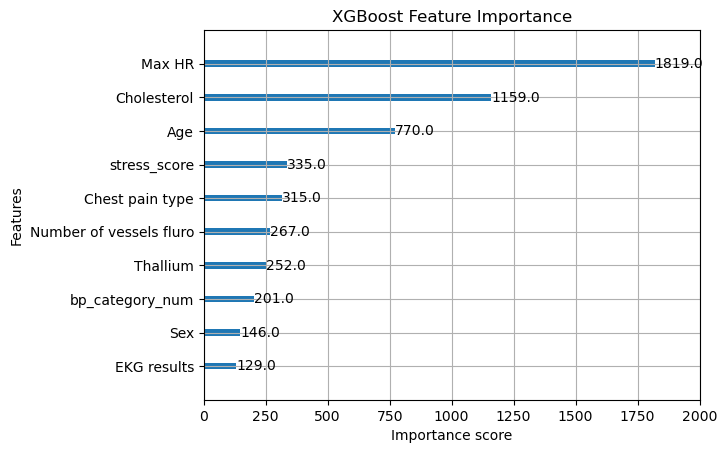

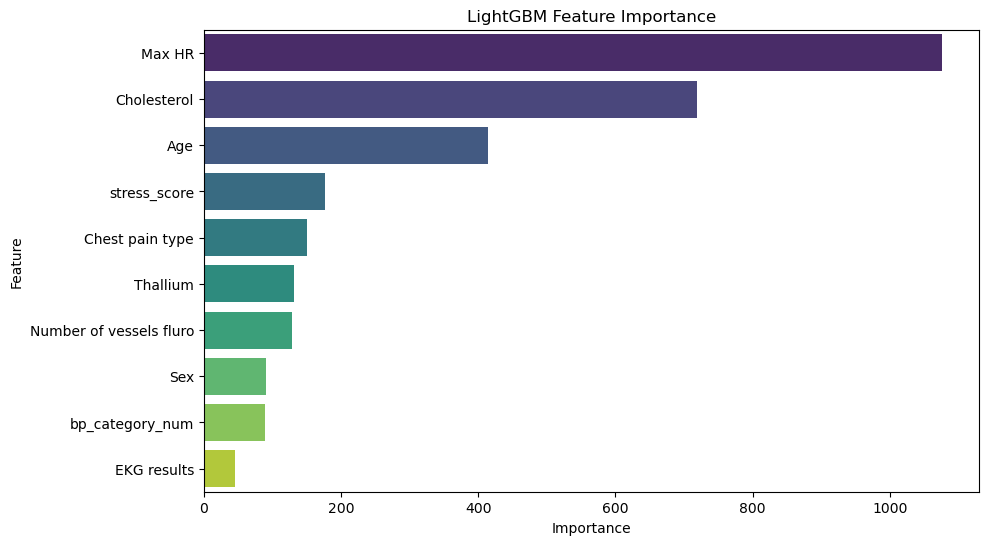

In [69]:
#feature importance of the two models
xgb.plot_importance(model_xgb, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()
importances = model_lgbm.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title("LightGBM Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
#put up a meta model using linear regression on the predictions of the two models and submit the predictions

from sklearn.linear_model import LinearRegression
meta_X = np.column_stack((preds_xgb, preds_lgbm))
meta_model = LinearRegression()
meta_model.fit(meta_X, final_preds)
meta_preds = meta_model.predict(meta_X)
d={'id': testing['id'], 'Heart Disease': meta_preds}
submission = pd.DataFrame(d)
submission.to_csv("submission_meta_model.csv", index=False)


In [73]:
#put up a meta model using decision tree on predictions on the predictions of the two models and submit the predictions
from sklearn.tree import DecisionTreeRegressor
meta_X = np.column_stack((preds_xgb, preds_lgbm))
meta_model = DecisionTreeRegressor(random_state=42)
meta_model.fit(meta_X, final_preds)
meta_preds = meta_model.predict(meta_X)
d={'id': testing['id'], 'Heart Disease': meta_preds}
submission = pd.DataFrame(d)
submission.to_csv("submission_meta_model_tree.csv", index=False)